In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from transformers import BertModel


In [5]:
df = pd.read_csv('data/Fake_Real_Data.csv')

In [6]:
class_names = {'Real': 0, 'Fake': 1}
df['label'] = df['label'].map(class_names)

df.head()

,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,1
1,U.S. conservative leader optimistic of common ...,0
2,"Trump proposes U.S. tax overhaul, stirs concer...",0
3,Court Forces Ohio To Allow Millions Of Illega...,1
4,Democrats say Trump agrees to work on immigrat...,0


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def encode_texts(texts, max_len=256):
    texts = pd.Series(texts)
    return tokenizer(
        texts.tolist(),
        add_special_tokens=True,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Text'], df['label'], test_size=0.1, random_state=42
)

train_encodings = encode_texts(train_texts)
val_encodings = encode_texts(val_texts)

train_dataset = torch.utils.data.TensorDataset(train_encodings['input_ids'],
                                               train_encodings['attention_mask'],
                                               torch.tensor(train_labels.values))
val_dataset = torch.utils.data.TensorDataset(val_encodings['input_ids'],
                                             val_encodings['attention_mask'],
                                             torch.tensor(val_labels.values))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3
total_steps = len(train_loader) * num_epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Avg Loss: {total_loss/len(train_loader):.4f}")


Training Epoch 1:   0%|          | 0/557 [00:00<?, ?it/s]

Epoch 1 | Avg Loss: 0.0313


Training Epoch 2:   0%|          | 0/557 [00:00<?, ?it/s]

Epoch 2 | Avg Loss: 0.0006


Training Epoch 3:   0%|          | 0/557 [00:00<?, ?it/s]

Epoch 3 | Avg Loss: 0.0003


In [12]:
model.eval()
preds, true_labels = [], []

for batch in tqdm(val_loader, desc="Validation"):
    input_ids, attention_mask, labels = [b.to(device) for b in batch]
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

print("Accuracy:", accuracy_score(true_labels, preds))
print(classification_report(true_labels, preds))


Validation:   0%|          | 0/31 [00:00<?, ?it/s]

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       513
           1       1.00      1.00      1.00       477

    accuracy                           1.00       990
   macro avg       1.00      1.00      1.00       990
weighted avg       1.00      1.00      1.00       990



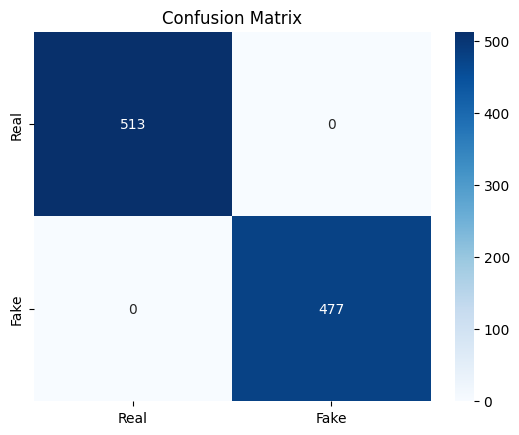

In [13]:
cm = confusion_matrix(true_labels, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.title("Confusion Matrix")
plt.show()


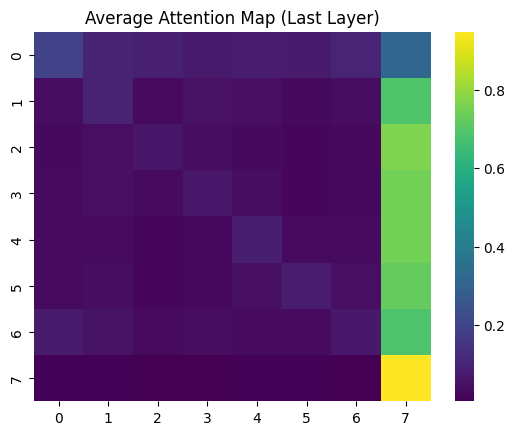

In [ ]:
# Extract attention weights from base BERT
bert_model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)
inputs = tokenizer("This is a fake news article", return_tensors="pt")
outputs = bert_model(**inputs)
attentions = outputs.attentions[-1][0]  # last layer attention

tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
sns.heatmap(
    attentions.mean(0).detach().cpu().numpy(),
    xticklabels=tokens,
    yticklabels=tokens,
    cmap="viridis"
)
plt.title("Average Attention Map (Last Layer)")
plt.show()


In [ ]:
# Create a directory to save your model
save_directory = "bert-model-saved"

# Save model, tokenizer, and config
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to '{save_directory}/'")


In [ ]:
# Load fine-tuned model and tokenizer
load_directory = "bert-model-saved"
tokenizer = BertTokenizer.from_pretrained(load_directory)
model = BertForSequenceClassification.from_pretrained(load_directory)
model.eval()  # important for inference

# Define a prediction function
def predict_fake_news(text):
    # Preprocess text for BERT
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=256
    )

    # Disable gradient computation for inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Get logits and predicted class
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()

    # Map numeric labels to human-readable labels
    label_map = {0: "Real", 1: "Fake"}
    return label_map[predicted_class]


print(predict_fake_news("Top Trump Surrogate BRUTALLY Stabs Him In The Back"))
